In [1]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt


STACKING DICOM SLICES INTO 3D VOLUME :

In [ ]:
#Reading DICOM directory
dicom_folder = r'./Brain Spy/week 2/archive/ST000001/SE000001'

dicom_files = [pydicom.dcmread(os.path.join(dicom_folder, f))
               for f in os.listdir(dicom_folder)
               if f.endswith('.dcm')]

# Sort by ImageLocation
dicom_files.sort(key=lambda x: float(x.ImagePositionPatient[2]))

# Stack pixel arrays into a 3D volume (Z, Y, X)
volume = np.stack([ds.pixel_array for ds in dicom_files], axis=0)

EXTRACTING METADATA FROM DICOM FILE :

In [12]:
dicom_file = dicom_files[0]

patient_name = dicom_file.get("PatientName", "N/A")
study_date = dicom_file.get("StudyDate", "N/A")
modality = dicom_file.get("Modality", "N/A")
pixel_spacing = dicom_file.get("PixelSpacing", "N/A")
slice_thickness = dicom_file.get("SliceThickness", "N/A")
image_position = dicom_file.get("ImagePositionPatient", "N/A")
image_orientation = dicom_file.get("ImageOrientationPatient", "N/A")
instance_number = dicom_file.get("InstanceNumber", "N/A")

# Print extracted metadata
print(f"Patient Name         : {patient_name}")
print(f"Study Date           : {study_date}")
print(f"Modality             : {modality}")
print(f"Pixel Spacing        : {pixel_spacing}")
print(f"Slice Thickness      : {slice_thickness}")
print(f"Image Position       : {image_position}")
print(f"Image Orientation    : {image_orientation}")
print(f"Instance Number      : {instance_number}")

Patient Name         : Anonymous
Study Date           : 20230703
Modality             : MR
Pixel Spacing        : [0.9765625, 0.9765625]
Slice Thickness      : 15
Image Position       : [-122.05163208127, -141.54345208235, -46.097605033182]
Image Orientation    : [0.99964332580566, 0.01352605503052, 0.02302792668342, -0.0134195787832, 0.99989855289459, -0.0047720880247]
Instance Number      : 7


These information tell us that:
1. Patient name has not been revealed for privacy.
2. This is a MRI scan of the brain.
3. each pixel corresponds to 0.98mm*0.98mm in real world.
4. The spacing between 2 slices in the imaging is 15mm.
5. Image Position represents the first voxel in paient's coordinate system.
6. Image Orientation array is useful to know how the slices are aligned. It is particularly useful when the images are not alinged in standard saggital, coronal or axial axes.
7. Instance number is used when we want to reconstruct the the slices in order.

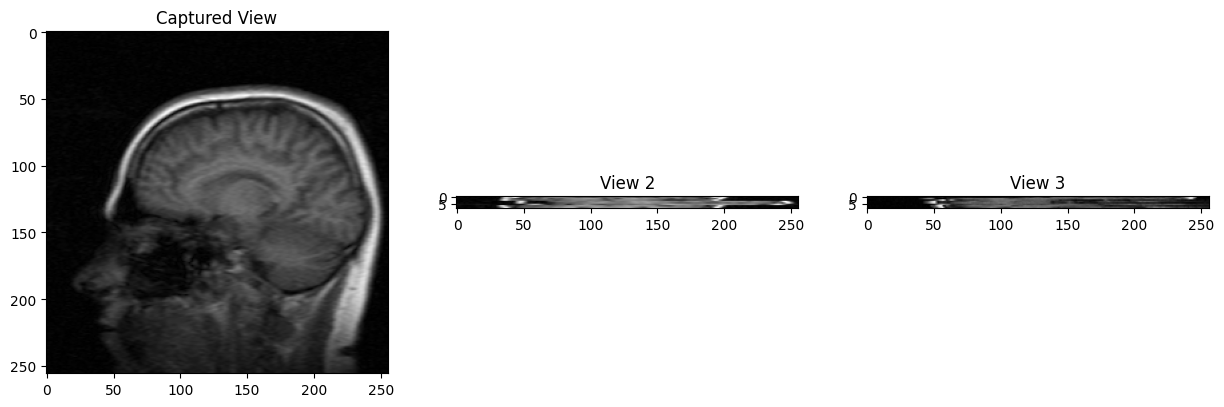

In [26]:
volume = volume.astype(np.float32)
volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume)) #Normalising for better visualisation

# Define midpoints
mid_z = volume.shape[0] // 2  
mid_y = volume.shape[1] // 2  
mid_x = volume.shape[2] // 2  

# Plot views
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# CAPTURED VIEW
axes[0].imshow(volume[mid_z, :, :], cmap='gray')
axes[0].set_title('Captured View')

# VIEW 2
axes[1].imshow(volume[:, mid_y, :], cmap='gray')
axes[1].set_title('View 2')

# VIEW 3
axes[2].imshow(volume[:, :, mid_x], cmap='gray')
axes[2].set_title('View 3')

plt.show()

The above plot shows the middle cross-section (which will apporoimately show the largest plot) for the Axial, Coronal, and Saggital views. We can clearly conclude that the data has been collected mainly to study the captured view as the gap between images in the given view is very large (15mm as extracted from the metadata). So we will mainly plot a static map of given views.

In [ ]:
print(volume.shape)

(9, 256, 256)


This means that we can plot 9 slices from this DICOM file

STATIC PLOT OF THE DICOM IMAGES :

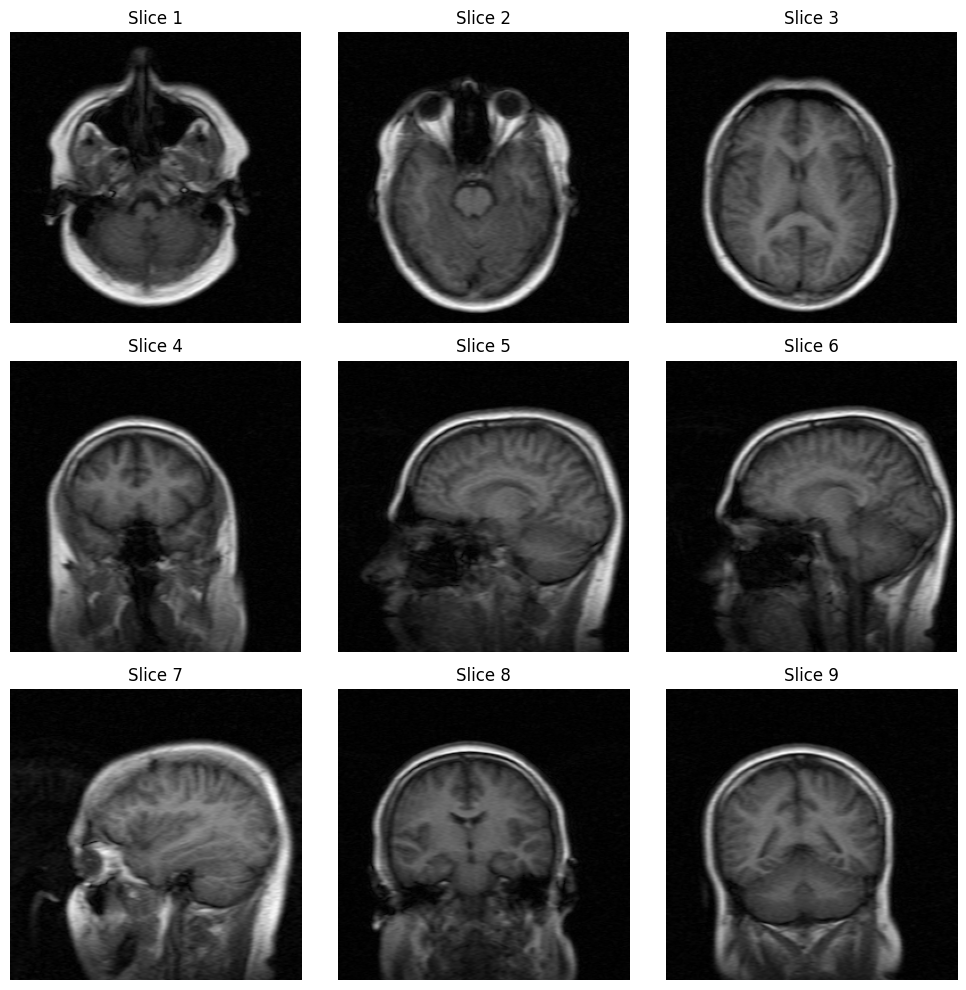

In [25]:
num_slices = 9

# 3 rows x 3 cols for 9 slices
cols = 3
rows = 3

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

# Flatten axes for easy indexing
axes = axes.flatten()

for i in range(num_slices):
    axes[i].imshow(volume[i, :, :], cmap='gray')
    axes[i].set_title(f"Slice {i+1}")
    axes[i].axis('off')

# Hide any unused subplots
for i in range(num_slices, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


1. The chosen dataset has scanned all different views of the brain.
2. It is not much detailed i.e. we cannot extract inforormation apart from the scanned images.
3. This also shows that stacking this kind of dataset does not hold much value.

We can also construct an affine matrix throough which we can again map real world coordinates to voxel coordinates and vice versa. It works in the same way as shown in NIfTI visualisation.

In [27]:
row_cosine = np.array(dicom_file.ImageOrientationPatient[:3])
col_cosine = np.array(dicom_file.ImageOrientationPatient[3:])
normal = np.cross(row_cosine, col_cosine)

pixel_spacing = np.array(dicom_file.PixelSpacing)  # [dy, dx]
slice_thickness = float(dicom_file.SliceThickness)
origin = np.array(dicom_file.ImagePositionPatient)

affine = np.eye(4)
affine[:3, 0] = row_cosine * pixel_spacing[1]       # x-axis (columns)
affine[:3, 1] = col_cosine * pixel_spacing[0]       # y-axis (rows)
affine[:3, 2] = normal * slice_thickness            # z-axis (slice direction)
affine[:3, 3] = origin                               # offset (position of voxel [0, 0, 0])

print(affine)

[[ 9.76214185e-01 -1.31050574e-02 -3.46352071e-01 -1.22051632e+02]
 [ 1.32090381e-02  9.76463431e-01  6.69204130e-02 -1.41543452e+02]
 [ 2.24882097e-02 -4.66024221e-03  1.49958514e+01 -4.60976050e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
